# Text modeling

## Lecture plan

- Modeling the *contents* of text.  
- [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf): a (relatively) simple approach.  
   - Basic premises of tf-idf.
- Applying *tf-idf* in Python.
- A brief tour of other methods.

## Load libraries

In [1]:
import numpy as np
from scipy.spatial.distance import cosine

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Building models of text

> Building a model of the **contents** of a text document involves figuring out "what it's about". 

- Common use case in NLP.  
- Various techniques and approaches:
   - [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
   - [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
   - And much more!

### What are these models good for?

- [Information retrieval](https://en.wikipedia.org/wiki/Information_retrieval).
   - Given a *search query* and some set of *documents*, which documents are most relevant?
- [Document classification](https://en.wikipedia.org/wiki/Document_classification). 
   - Given a bunch of *documents*, what are their *categories*?
- [Keyword extraction](https://monkeylearn.com/keyword-extraction/).  
   - What are relevant *tags* or *keywords* to describe a document?  
- [Summarization](https://en.wikipedia.org/wiki/Automatic_summarization).  
   - Given a *document*, can we produce a readable *summary* of that document?
   
And much more.

### A long history of *models*

- NLP practitioners have been building models of text for decades.  
   - Even **sentiment analysis** counts as a model of text.
- In recent years, text modeling has improved considerably.
   - 2013: [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) like *word2vec* are introduced.  
   - 2017: [transformer](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) architecture is introduced.
   - 2022: [ChatGPT](https://chat.openai.com/) is released.
- We'll start with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf), a conceptual precursor to those more advanced methods.

## Introducing *tf-idf*

> [*Tf-idf*](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf), or **term frequency, inverse document frequency** is a technique for measuring how important a word is to a given document or corpus, adjusted for overall frequency.

### Basic premises

What's a document *about*?

- The contents of a document are in some sense the *words* that appear in it.  
- Documents with more similar *words* are, on average, about more similar things.
   - In Linguistics, this is known as the [distributional hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).  
   - 'you shall know the meaning of a word by the company it keeps'
- A "model" of a document is the **count vector** of all the words that appear in it. 
- Some words are just more frequent overall, so we should **adjust** for that.

### Before tf-idf: count vectors

> A **count vector** is a *vector* (list) indicating the number of times each word $w$ in a vocabulary occurs in some document $d$.
  
![Optional Caption](img/vector.png)

### Documents as *vectors*, similarity as *proximity*

> In **vector semantics**, the **cosine distance** between two document vectors can be used as a proxy for how similar those documents are. 

$\Large cosine(v, w) = \frac{v \cdot w}{|v||w|}$

- $v \cdot w$: *dot product* between $v$ and $w$.  
- $|v||w|$: size of $v$ and $w$. 

In [3]:
### Very close vectors
v1 = np.array([1, 2, 5, 6])
v2 = np.array([2, 3, 4, 7])
cosine(v1, v2)  ### imported from scipy.spatial.distance --> cosine distance
### usually people calculate cosine similarity, which is 1-cosine distance

0.024384321658394104

#### Check-in

Try to create two vectors with a larger `cosine` distance.

In [8]:
v1 = np.array([1, 2, 5, 6])
v2 = np.array([9, 8, 0, 0])
cosine(v1, v2)

0.7444452016427252

#### Distant vectors

- Vectors will be more *distant* if they have more *orthogonal* elements, i.e., they are uncorrelated. 

In [25]:
### Very close vectors
v1 = np.array([1, 2, 5, 6])
v2 = np.array([6, 0, 0, 1])
cosine(v1, v2)  ### imported from scipy.spatial.distance

0.7571666024450942

### Count vectors in Python (1)

- We can use the `CountVectorizer` class to create a count matrix for a bunch of documents.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [5]:
help(CountVectorizer)

Help on class CountVectorizer in module sklearn.feature_extraction.text:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  For an efficiency comparison of the different feature extractors, see
 |  :ref:`sphx_glr_au

In [6]:
# Sample documents
documents = [
    'the sky is blue',
    'the sun is bright',
    'the sun in the sky is bright',
    'we can see the shining sun, the bright sun'
]

### Count vectors in Python (2)

- We call `vectorizer.fit_transformer` on our documents.
- Then we convert that matrix to a `DataFrame`.

In [7]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()
# Fit and transform the documents
count_matrix = vectorizer.fit_transform(documents)
count_matrix

<4x11 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [8]:
# Convert the matrix to an array and label the columns and rows
count_array = count_matrix.toarray()
df = pd.DataFrame(count_array, columns=vectorizer.get_feature_names_out(), # extract the feature names form vectorizer. will give you all the words
                  index=[f"Document {i+1}" for i in range(len(documents))]) 
## count of the words that appear in the document across document itself
## each row is a count vector
## think of the words as features representing the doc
## lost all the info on words sequence
print(df)

            blue  bright  can  in  is  see  shining  sky  sun  the  we
Document 1     1       0    0   0   1    0        0    1    0    1   0
Document 2     0       1    0   0   1    0        0    0    1    1   0
Document 3     0       1    0   1   1    0        0    1    1    2   0
Document 4     0       1    1   0   0    1        1    0    2    2   1


### Count vectors in Python (3)

- Finally, we can compute the *cosine distance* between our documents.

In [9]:
### Cosine distance between doc 1 and doc 2
cosine(df.loc['Document 1'], df.loc['Document 2'])

0.5

In [10]:
### Cosine distance between doc 1 and doc 3
cosine(df.loc['Document 1'], df.loc['Document 3'])

0.33333333333333337

In [11]:
### Cosine distance between doc 2 and doc 3
cosine(df.loc['Document 2'], df.loc['Document 3'])

0.16666666666666663

### The problem with *counts*

- Some words are simply more **frequent overall**. 
- Using the *raw counts* of words does not control for the **uniqueness** of a given word to a given document.
   - E.g., "the" is extremely frequent, but doesn't tell us much about what a document is about.  
- Ideally, we'd have a way to calculate which words **uniquely co-occur**.

## tf-idf: a potential solution

> In [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Motivations), we compare the frequency of a word in a given document (**term frequency**) to the inverse frequency of that term across all documents (**inverse document frequency**). 

- $tf(t, d)$: *count* of term $t$ in document $d$.  
   - Just like our `CountVectorizer` before.
- $idf(t, D)$: how often does $t$ appear across all documents $D$?
   - This is a new term!

### Understanding inverse document frequency

> **Inverse document frequency** is measured in various different ways, but is meant to capture the *uniqueness* of a term to particular documents.

$\Large idf(t, D) = log(\frac{N}{df_t})$

- Where $N$ is the number of documents overall.  
- And $df_t$ is the number of documents in which $t$ occurs.

*eg:* you have 345 documents in your corpus, and 213 of those have word $f$ in it

$\Large idf(t, D) = \log(\frac{345} {213}) \sim \log(1.6) \sim 0.2$

if a word is in ALL the documents:  

$\Large idf(t, D) = \log(\frac{345} {345}) = \log(1) = 0$

#### Check-in

How will inverse document frequency change as a term occurs across more or less documents?

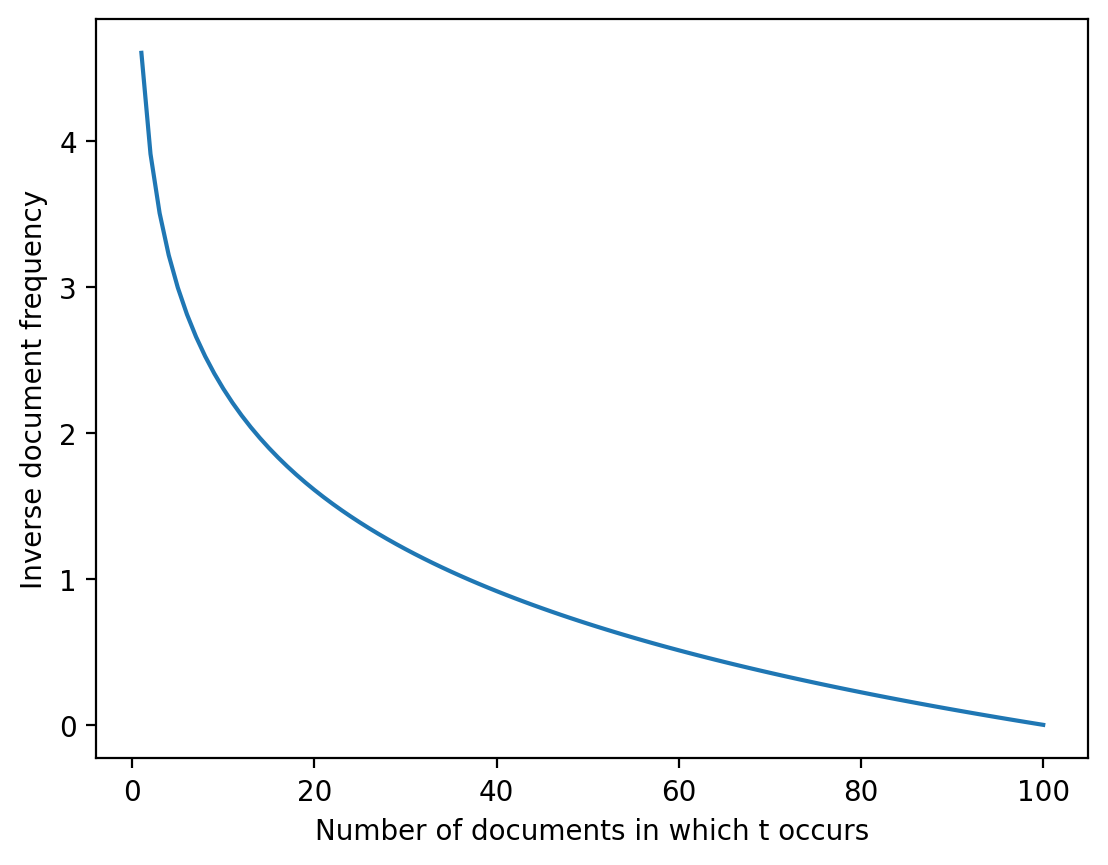

In [15]:
df_t =np.arange(1, 101)
N = 100
idf_t = np.log(N/df_t)
sns.lineplot(x=df_t, y= idf_t)
plt.xlabel("Number of documents in which t occurs")
plt.ylabel("Inverse document frequency");

#### Solution

In [34]:
### range of df_t values
df_t = np.arange(1, 101)
### Number of documents
N = 100
### idf

idf_t = np.log(N/df_t)

Text(0, 0.5, 'Inverse document frequency')

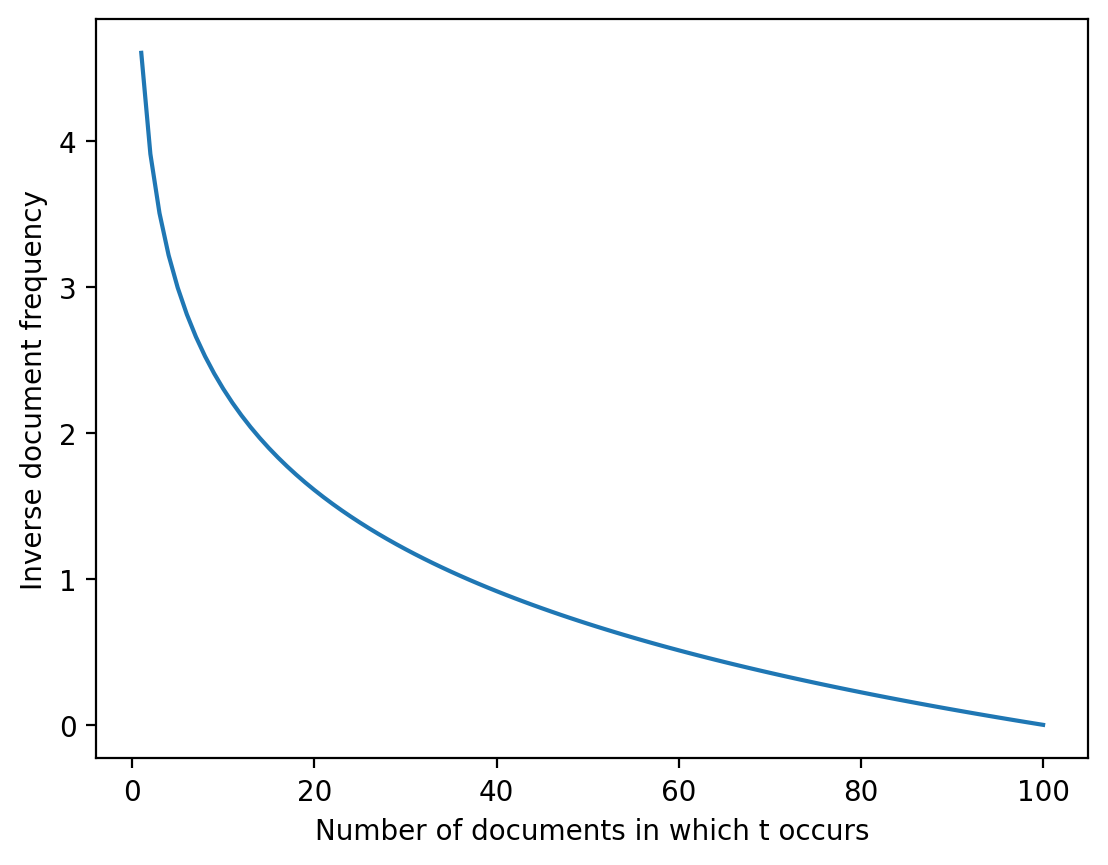

In [35]:
sns.lineplot(x = df_t, y = idf_t)
plt.xlabel("Number of documents in which t occurs")
plt.ylabel("Inverse document frequency")

### tf-idf: final explanation

- Again: basic premise is that we can *compare* documents based on whether they have similar words. 
- But some words are more **frequent**, so we control for those overall term frequencies.  
  - Common words like "the" and "good" will not *contribute* as much to the **representation** of a document.  
  - Less common words will make a bigger **impact**.

So how would this work in practice?

### tf-idf in Python (1)

- Syntactically, looks very similar to `CountVectorizer`!

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Sample documents
documents = [
    'the sky is blue',
    'the sun is bright',
    'the sun in the sky is bright',
    'we can see the shining sun, the bright sun'
]

### tf-idf in Python (2)

In [18]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()
# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)
# Get the feature names
feature_names = vectorizer.get_feature_names_out()

In [19]:
# Display the matrix
import pandas as pd
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df

# same sets of features as before, but values are scaled always less than 1

,blue,bright,can,in,is,see,shining,sky,sun,the,we
0,0.659191,0.000000,0.000000,0.000000,0.420753,0.000000,0.000000,0.519714,0.000000,0.343993,0.000000
1,0.000000,0.522109,0.000000,0.000000,0.522109,0.000000,0.000000,0.000000,0.522109,0.426858,0.000000
2,0.000000,0.321846,0.000000,0.504235,0.321846,0.000000,0.000000,0.397544,0.321846,0.526261,0.000000
3,0.000000,0.239102,0.374599,0.000000,0.000000,0.374599,0.374599,0.000000,0.478204,0.390963,0.374599


### tf-idf in Python (3)

- Now we can compare our documents.

In [40]:
### Distance between doc 1 and doc 2
cosine(df.loc[0], df.loc[1])

0.63348486857333

In [41]:
### Distance between doc 1 and doc 3
cosine(df.loc[0], df.loc[2])

0.476942561629634

In [42]:
### Distance between doc 2 and doc 3
cosine(df.loc[1], df.loc[2])

0.27124492054006366

## tf-idf, applied

- It's hard to see the *benefits* of *tf-idf* in such a small corpus of documents. 
- Let's look at a larger sample.  
- This will also allow us to see how *tf-idf* can be used for **text classification**.

### Step 1: load our dataset

- Let's use the *news groups* dataset from `sklearn`.

In [20]:
from sklearn.datasets import fetch_20newsgroups

In [22]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
# Load the 20 Newsgroups datasetn --> bunch of news documents of different categories
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Accessing the data
documents = newsgroups_data.data
categories = newsgroups_data.target

In [24]:
### A little under 20K documents
len(documents)

18846

In [25]:
len(set(categories))

20

In [26]:
### Example of some categories
newsgroups_data.target_names[0:4]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware']

In [27]:
newsgroups_data.target_names

# 'target names' are the actual names, 'categories' are just numbers

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Step 2: Use `TfidfVectorizer`

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2, max_features=None) ## max document freq set to 0.5, and min doc freq is 2

In [29]:
# Fit and transform our data
X = vectorizer.fit_transform(documents)

In [30]:
X ## sparse matrix

<18846x51840 sparse matrix of type '<class 'numpy.float64'>'
	with 1147174 stored elements in Compressed Sparse Row format>

### Step 2b: Checking our learned feature names

- Now, our `feature_names` is a *much longer vector*.
- It's *every word* in our corpus.

In [31]:
# Get the feature names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

51840

In [32]:
# Random sample
feature_names[10000:10010]

array(['boulders', 'boulevard', 'bounce', 'bounced', 'bounces',
       'bouncing', 'bound', 'boundaries', 'boundary', 'bounded'],
      dtype=object)

### Step 3: Train a classifier

- We can use these as **features** to train a classifier to predict the *category* of an article.

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
# Initialize the classifier
# no train test split here which is NEEDED
clf = LogisticRegression(random_state=42, max_iter=1000)

In [35]:
# Train the classifier
clf.fit(X, categories)

LogisticRegression(max_iter=1000, random_state=42)

### Step 4: Evaluate the classifier

- Using these **learned features**, how accurately can we predict the category of a piece of text?

In [36]:
from sklearn.metrics import accuracy_score, classification_report

In [37]:
# Predict the labels for the test set
predictions = clf.predict(X)

In [38]:
# Accuracy score
accuracy = accuracy_score(categories, predictions)
print(f"Classification accuracy: {accuracy:.4f}")

Classification accuracy: 0.8962


In [42]:
report = classification_report(categories, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       799
           1       0.89      0.88      0.88       973
           2       0.86      0.84      0.85       985
           3       0.87      0.87      0.87       982
           4       0.94      0.88      0.91       963
           5       0.94      0.91      0.93       988
           6       0.89      0.88      0.89       975
           7       0.92      0.89      0.90       990
           8       0.62      0.96      0.75       996
           9       0.97      0.93      0.95       994
          10       0.99      0.94      0.97       999
          11       0.97      0.90      0.93       991
          12       0.90      0.89      0.90       984
          13       0.95      0.94      0.94       990
          14       0.95      0.93      0.94       987
          15       0.88      0.94      0.91       997
          16       0.87      0.92      0.90       910
          17       0.97    

#### Check-in

Our accuracy was pretty high. But was there anything we should've done *differently* in how we fit our `TfidfVectorizer` and our `LogisticRegression` model?

In [71]:
### Your answer here

### The importance of cross-validation

- Ordinarily, we would do a **train-test split**.  
  - I skipped that for this demonstration, because there was already enough going on!
- But a train-test split important is important both for:
  - Fitting our *classifier*: train on some documents, test on others.  
  - Learning our `TfidfVectorizer` features: `.fit_transform` on train set, `transform` test set.
- Critical for avoiding **data leakage**.

### tf-idf: wrap-up

- Tf-idf is an approach to **modeling** the contents of text.  
  - Gives us **features** to represent our text with.
- In combination with other approaches (e.g., **classification**), this is really powerful.  
- When we cover more advanced **machine learning** methods, these *applications* will make even more sense.

## Modeling text: a very brief tour

- tf-idf is certainly not the only game in town; these days it's not used as frequently.  
- Other approaches worth knowing about if you go into NLP.
   - [Latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).
   - [Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). 
   - [Word embeddings](https://en.wikipedia.org/wiki/Word_embedding). 
- Many of these other approaches improve upon tf-idf by discovering **latent "topics" or "dimensions"** among the term-document matrix.
- Some of these topics will be discussed later in the quarter, when we cover **deep learning**. 

## Lecture wrap-up

- Building **models** of text is a common use case in NLP and CSS.
   - Helpful for retrieval, classification, and more. 
- One simple approach is to represent documents as the **words** they contain.
- Tf-idf does that, and **normalizes** for the frequency of words across all documents. 
- More modern approaches improve upon tf-idf.